## Import Library

In [1]:
import os
import json
import warnings
import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    StratifiedKFold, cross_val_score
)
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, confusion_matrix,
    classification_report, f1_score, precision_recall_curve, average_precision_score,
    recall_score,
)
import joblib
from catboost import CatBoostClassifier
from IPython.display import display

import optuna

warnings.filterwarnings('ignore', category=UserWarning)

project_path = "E:/Project/HepatitisC-Prediction/"
file_path = f"{project_path}/Dataset/cleaned_dataset.csv"
result_path = f"{project_path}/Result"
hyper_path = f"{result_path}/Hyperparameter"
model_path = f"{project_path}/Models"

## Load Dataset

In [2]:
df = pd.read_csv(file_path)
print(df.shape)
print(df.info())

(3687, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687 entries, 0 to 3686
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  3687 non-null   int64  
 1   gender               3687 non-null   int64  
 2   jaundice_history     3687 non-null   int64  
 3   receive_transfusion  3687 non-null   int64  
 4   liver_condition      3687 non-null   int64  
 5   injectable_drug_use  3687 non-null   int64  
 6   drug_use             3687 non-null   int64  
 7   alcohol_consumption  3687 non-null   int64  
 8   alt                  3687 non-null   float64
 9   albumin              3687 non-null   float64
 10  alp                  3687 non-null   float64
 11  ast                  3687 non-null   float64
 12  bun                  3687 non-null   float64
 13  cholesterol          3687 non-null   float64
 14  cpk                  3687 non-null   float64
 15  creatinine           3687 n

## Load Scaler

In [3]:
scaler_existing = joblib.load(f"{model_path}/scaler.joblib")
print(f"Scaler berhasil dimuat")

Scaler berhasil dimuat


In [4]:
df_train = df[df['dataset'] == 'train']
df_test = df[df['dataset'] == 'test']

X_train = df_train.drop(columns=['hcv_status', 'dataset'])
y_train = df_train['hcv_status']

X_test = df_test.drop(columns=['hcv_status', 'dataset'])
y_test = df_test['hcv_status']

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (3198, 26)
Test shape: (489, 26)


## Hyperparameter Tuning (5-Fold CV)

In [5]:
class EarlyStoppingCallback:
    def __init__(self, patience=100, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_value = None
        self.trials_without_improvement = 0
    
    def __call__(self, study, trial):
        if self.best_value is None:
            self.best_value = study.best_value
            return
        
        if study.best_value - self.best_value > self.min_delta:
            self.best_value = study.best_value
            self.trials_without_improvement = 0
        else:
            self.trials_without_improvement += 1
        
        if self.trials_without_improvement >= self.patience:
            study.stop()
            print(f"\nEarly stopping triggered! No improvement after {self.patience} trials")
            print(f"Best value: {self.best_value:.4f}")

In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    iterations = trial.suggest_int("iterations", 100, 200)  
    learning_rate = trial.suggest_float("learning_rate", 0.03, 0.08)
    depth = trial.suggest_int("depth", 4, 6)
    l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 3, 7)
    min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 5, 20)
    
    model = Pipeline([
        ('scaler', scaler_existing),
        ('classifier', CatBoostClassifier(
            iterations=iterations,
            learning_rate=learning_rate,
            depth=depth,
            l2_leaf_reg=l2_leaf_reg,
            min_data_in_leaf=min_data_in_leaf,
            verbose=False,
            loss_function="Logloss",
            allow_writing_files=False,
            random_state=42,
        ))
    ])

    train_acc_list = []
    val_acc_list = []
    val_recall_list = []

    for fold_idx, (train_idx, valid_idx) in enumerate(cv.split(X_train, y_train)):
        X_t, X_v = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_t, y_v = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model.fit(X_t, y_t)

        train_pred = model.predict(X_t)
        train_acc = accuracy_score(y_t, train_pred)
        train_acc_list.append(train_acc)

        val_pred = model.predict(X_v)
        val_acc = accuracy_score(y_v, val_pred)
        val_recall = recall_score(y_v, val_pred, average="macro")

        val_acc_list.append(val_acc)
        val_recall_list.append(val_recall)
        
        intermediate_recall = np.mean(val_recall_list)
        trial.report(intermediate_recall, fold_idx)
        
        if trial.should_prune():
            raise optuna.TrialPruned()

    mean_train_acc = np.mean(train_acc_list)
    mean_val_acc = np.mean(val_acc_list)
    mean_val_recall = np.mean(val_recall_list)

    print(f"Trial {trial.number}: "
          f"Train Acc = {mean_train_acc:.4f}, "
          f"Val Acc = {mean_val_acc:.4f}, "
          f"Val Recall = {mean_val_recall:.4f}")

    return mean_val_recall

In [ ]:
study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=50,  # Tunggu 10 trial pertama sebelum mulai prune
        n_warmup_steps=2,  # Tunggu 2 fold sebelum mulai prune
        interval_steps=1,  # Check setiap fold
    ),
    sampler=optuna.samplers.TPESampler(seed=42)
)

early_stopping = EarlyStoppingCallback(patience=300, min_delta=0.0001)
study.optimize(objective, n_trials=1000, callbacks=[early_stopping])

print("\n" + "=" * 60)
print("Tuning Selesai!")
print("=" * 60)
print(f"Total trials: {len(study.trials)}")
print(
    f"Total trials pruned: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}"
)
print(
    f"Total trials berhasil: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}"
)

[I 2025-12-13 21:40:30,964] A new study created in memory with name: no-name-9c08204f-d181-4ca3-b94d-ee3608e290a6
[I 2025-12-13 21:40:32,548] Trial 0 finished with value: 0.9706024686520376 and parameters: {'iterations': 174, 'learning_rate': 0.06397892252559151, 'depth': 4, 'l2_leaf_reg': 5, 'min_data_in_leaf': 6}. Best is trial 0 with value: 0.9706024686520376.


Trial 0: Train Acc = 0.9909, Val Acc = 0.9706, Val Recall = 0.9706


[I 2025-12-13 21:40:33,438] Trial 1 finished with value: 0.9655995297805642 and parameters: {'iterations': 103, 'learning_rate': 0.06278604280220515, 'depth': 4, 'l2_leaf_reg': 3, 'min_data_in_leaf': 10}. Best is trial 0 with value: 0.9706024686520376.


Trial 1: Train Acc = 0.9828, Val Acc = 0.9656, Val Recall = 0.9656


[I 2025-12-13 21:40:35,114] Trial 2 finished with value: 0.9665360501567399 and parameters: {'iterations': 167, 'learning_rate': 0.03200524210129291, 'depth': 5, 'l2_leaf_reg': 7, 'min_data_in_leaf': 20}. Best is trial 0 with value: 0.9706024686520376.


Trial 2: Train Acc = 0.9844, Val Acc = 0.9665, Val Recall = 0.9665


[I 2025-12-13 21:40:36,281] Trial 3 finished with value: 0.9646630094043888 and parameters: {'iterations': 116, 'learning_rate': 0.033887419936897444, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 5}. Best is trial 0 with value: 0.9706024686520376.


Trial 3: Train Acc = 0.9816, Val Acc = 0.9647, Val Recall = 0.9647


[I 2025-12-13 21:40:38,180] Trial 4 finished with value: 0.9734159482758621 and parameters: {'iterations': 189, 'learning_rate': 0.06845718124516502, 'depth': 5, 'l2_leaf_reg': 4, 'min_data_in_leaf': 19}. Best is trial 4 with value: 0.9734159482758621.


Trial 4: Train Acc = 0.9966, Val Acc = 0.9734, Val Recall = 0.9734


[I 2025-12-13 21:40:40,047] Trial 5 finished with value: 0.9749784482758621 and parameters: {'iterations': 196, 'learning_rate': 0.06992464741053196, 'depth': 5, 'l2_leaf_reg': 4, 'min_data_in_leaf': 10}. Best is trial 5 with value: 0.9749784482758621.


Trial 5: Train Acc = 0.9972, Val Acc = 0.9750, Val Recall = 0.9750


[I 2025-12-13 21:40:41,613] Trial 6 finished with value: 0.9724794278996866 and parameters: {'iterations': 128, 'learning_rate': 0.06704144748621976, 'depth': 6, 'l2_leaf_reg': 4, 'min_data_in_leaf': 15}. Best is trial 5 with value: 0.9749784482758621.


Trial 6: Train Acc = 0.9967, Val Acc = 0.9725, Val Recall = 0.9725


[I 2025-12-13 21:40:43,355] Trial 7 finished with value: 0.9690370297805643 and parameters: {'iterations': 173, 'learning_rate': 0.03759571554896214, 'depth': 5, 'l2_leaf_reg': 6, 'min_data_in_leaf': 7}. Best is trial 5 with value: 0.9749784482758621.


Trial 7: Train Acc = 0.9880, Val Acc = 0.9690, Val Recall = 0.9690


[I 2025-12-13 21:40:45,573] Trial 8 finished with value: 0.9693495297805643 and parameters: {'iterations': 144, 'learning_rate': 0.040986813914801315, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 7}. Best is trial 5 with value: 0.9749784482758621.


Trial 8: Train Acc = 0.9941, Val Acc = 0.9694, Val Recall = 0.9693


[I 2025-12-13 21:40:47,540] Trial 9 finished with value: 0.9687245297805642 and parameters: {'iterations': 143, 'learning_rate': 0.03445470046660019, 'depth': 6, 'l2_leaf_reg': 5, 'min_data_in_leaf': 6}. Best is trial 5 with value: 0.9749784482758621.


Trial 9: Train Acc = 0.9901, Val Acc = 0.9687, Val Recall = 0.9687


[I 2025-12-13 21:40:49,272] Trial 10 finished with value: 0.9727889890282132 and parameters: {'iterations': 200, 'learning_rate': 0.07949144969575071, 'depth': 4, 'l2_leaf_reg': 6, 'min_data_in_leaf': 13}. Best is trial 5 with value: 0.9749784482758621.


Trial 10: Train Acc = 0.9944, Val Acc = 0.9728, Val Recall = 0.9728


[I 2025-12-13 21:40:51,403] Trial 11 finished with value: 0.9759169278996864 and parameters: {'iterations': 196, 'learning_rate': 0.07691462382511399, 'depth': 5, 'l2_leaf_reg': 4, 'min_data_in_leaf': 18}. Best is trial 11 with value: 0.9759169278996864.


Trial 11: Train Acc = 0.9980, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 21:40:53,367] Trial 12 finished with value: 0.9731024686520374 and parameters: {'iterations': 200, 'learning_rate': 0.07877918267976325, 'depth': 5, 'l2_leaf_reg': 4, 'min_data_in_leaf': 16}. Best is trial 11 with value: 0.9759169278996864.


Trial 12: Train Acc = 0.9986, Val Acc = 0.9731, Val Recall = 0.9731


[I 2025-12-13 21:40:55,148] Trial 13 finished with value: 0.9734159482758621 and parameters: {'iterations': 180, 'learning_rate': 0.052304037564889376, 'depth': 5, 'l2_leaf_reg': 4, 'min_data_in_leaf': 10}. Best is trial 11 with value: 0.9759169278996864.


Trial 13: Train Acc = 0.9937, Val Acc = 0.9734, Val Recall = 0.9734


[I 2025-12-13 21:40:56,471] Trial 14 finished with value: 0.9702899686520376 and parameters: {'iterations': 158, 'learning_rate': 0.07311718915473701, 'depth': 4, 'l2_leaf_reg': 5, 'min_data_in_leaf': 11}. Best is trial 11 with value: 0.9759169278996864.


Trial 14: Train Acc = 0.9917, Val Acc = 0.9703, Val Recall = 0.9703


[I 2025-12-13 21:40:58,842] Trial 15 finished with value: 0.9749764890282131 and parameters: {'iterations': 188, 'learning_rate': 0.05650243470981654, 'depth': 6, 'l2_leaf_reg': 4, 'min_data_in_leaf': 17}. Best is trial 11 with value: 0.9759169278996864.


Trial 15: Train Acc = 0.9980, Val Acc = 0.9750, Val Recall = 0.9750


[I 2025-12-13 21:41:00,451] Trial 16 finished with value: 0.9731034482758621 and parameters: {'iterations': 159, 'learning_rate': 0.07265401143219849, 'depth': 5, 'l2_leaf_reg': 6, 'min_data_in_leaf': 13}. Best is trial 11 with value: 0.9759169278996864.


Trial 16: Train Acc = 0.9943, Val Acc = 0.9731, Val Recall = 0.9731


[I 2025-12-13 21:41:02,962] Trial 17 finished with value: 0.9777938871473355 and parameters: {'iterations': 188, 'learning_rate': 0.05676789261281223, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 17 with value: 0.9777938871473355.


Trial 17: Train Acc = 0.9987, Val Acc = 0.9778, Val Recall = 0.9778


[I 2025-12-13 21:41:05,697] Trial 18 finished with value: 0.9740399686520377 and parameters: {'iterations': 184, 'learning_rate': 0.046610703533860584, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 17 with value: 0.9777938871473355.


Trial 18: Train Acc = 0.9973, Val Acc = 0.9740, Val Recall = 0.9740


[I 2025-12-13 21:41:07,972] Trial 19 finished with value: 0.976228448275862 and parameters: {'iterations': 163, 'learning_rate': 0.05755616729423317, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 15}. Best is trial 17 with value: 0.9777938871473355.


Trial 19: Train Acc = 0.9977, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 21:41:10,303] Trial 20 finished with value: 0.9746639890282133 and parameters: {'iterations': 155, 'learning_rate': 0.055256587379127343, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 15}. Best is trial 17 with value: 0.9777938871473355.


Trial 20: Train Acc = 0.9973, Val Acc = 0.9747, Val Recall = 0.9747


[I 2025-12-13 21:41:12,468] Trial 21 finished with value: 0.974663989028213 and parameters: {'iterations': 168, 'learning_rate': 0.04964421662468003, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 17 with value: 0.9777938871473355.


Trial 21: Train Acc = 0.9964, Val Acc = 0.9747, Val Recall = 0.9747


[I 2025-12-13 21:41:14,715] Trial 22 finished with value: 0.9765419278996864 and parameters: {'iterations': 180, 'learning_rate': 0.059577465114528286, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 20}. Best is trial 17 with value: 0.9777938871473355.


Trial 22: Train Acc = 0.9986, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 21:41:17,052] Trial 23 finished with value: 0.9740409482758621 and parameters: {'iterations': 178, 'learning_rate': 0.05938063575782664, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 15}. Best is trial 17 with value: 0.9777938871473355.


Trial 23: Train Acc = 0.9987, Val Acc = 0.9740, Val Recall = 0.9740


[I 2025-12-13 21:41:19,211] Trial 24 finished with value: 0.9749784482758621 and parameters: {'iterations': 167, 'learning_rate': 0.059810562144903205, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 19}. Best is trial 17 with value: 0.9777938871473355.


Trial 24: Train Acc = 0.9980, Val Acc = 0.9750, Val Recall = 0.9750


[I 2025-12-13 21:41:21,097] Trial 25 finished with value: 0.9712255094043888 and parameters: {'iterations': 146, 'learning_rate': 0.04396811921531715, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 20}. Best is trial 17 with value: 0.9777938871473355.


Trial 25: Train Acc = 0.9948, Val Acc = 0.9712, Val Recall = 0.9712


[I 2025-12-13 21:41:22,999] Trial 26 finished with value: 0.9702889890282131 and parameters: {'iterations': 132, 'learning_rate': 0.048290047905756764, 'depth': 6, 'l2_leaf_reg': 7, 'min_data_in_leaf': 16}. Best is trial 17 with value: 0.9777938871473355.


Trial 26: Train Acc = 0.9919, Val Acc = 0.9703, Val Recall = 0.9703


[I 2025-12-13 21:41:25,711] Trial 27 finished with value: 0.9743534482758621 and parameters: {'iterations': 189, 'learning_rate': 0.05317204986614327, 'depth': 6, 'l2_leaf_reg': 4, 'min_data_in_leaf': 17}. Best is trial 17 with value: 0.9777938871473355.


Trial 27: Train Acc = 0.9973, Val Acc = 0.9744, Val Recall = 0.9744


[I 2025-12-13 21:41:27,844] Trial 28 finished with value: 0.9749784482758621 and parameters: {'iterations': 166, 'learning_rate': 0.059813447655213674, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 14}. Best is trial 17 with value: 0.9777938871473355.


Trial 28: Train Acc = 0.9979, Val Acc = 0.9750, Val Recall = 0.9750


[I 2025-12-13 21:41:30,143] Trial 29 finished with value: 0.9734130094043886 and parameters: {'iterations': 173, 'learning_rate': 0.06454626963434423, 'depth': 6, 'l2_leaf_reg': 5, 'min_data_in_leaf': 20}. Best is trial 17 with value: 0.9777938871473355.


Trial 29: Train Acc = 0.9977, Val Acc = 0.9734, Val Recall = 0.9734


[I 2025-12-13 21:41:32,835] Trial 30 finished with value: 0.9740399686520377 and parameters: {'iterations': 178, 'learning_rate': 0.05692311463137795, 'depth': 6, 'l2_leaf_reg': 4, 'min_data_in_leaf': 17}. Best is trial 17 with value: 0.9777938871473355.


Trial 30: Train Acc = 0.9975, Val Acc = 0.9740, Val Recall = 0.9740


[I 2025-12-13 21:41:35,074] Trial 31 finished with value: 0.9737284482758621 and parameters: {'iterations': 193, 'learning_rate': 0.06292819448684746, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 17 with value: 0.9777938871473355.


Trial 31: Train Acc = 0.9970, Val Acc = 0.9737, Val Recall = 0.9737


[I 2025-12-13 21:41:37,109] Trial 32 finished with value: 0.9743544278996865 and parameters: {'iterations': 184, 'learning_rate': 0.0750365682502157, 'depth': 5, 'l2_leaf_reg': 4, 'min_data_in_leaf': 19}. Best is trial 17 with value: 0.9777938871473355.


Trial 32: Train Acc = 0.9977, Val Acc = 0.9744, Val Recall = 0.9744


[I 2025-12-13 21:41:38,826] Trial 33 finished with value: 0.970603448275862 and parameters: {'iterations': 192, 'learning_rate': 0.05150772349198496, 'depth': 4, 'l2_leaf_reg': 3, 'min_data_in_leaf': 16}. Best is trial 17 with value: 0.9777938871473355.


Trial 33: Train Acc = 0.9906, Val Acc = 0.9706, Val Recall = 0.9706


[I 2025-12-13 21:41:40,920] Trial 34 finished with value: 0.9743524686520375 and parameters: {'iterations': 185, 'learning_rate': 0.06494909347017754, 'depth': 5, 'l2_leaf_reg': 5, 'min_data_in_leaf': 19}. Best is trial 17 with value: 0.9777938871473355.


Trial 34: Train Acc = 0.9955, Val Acc = 0.9744, Val Recall = 0.9744


[I 2025-12-13 21:41:42,915] Trial 35 finished with value: 0.9756024686520377 and parameters: {'iterations': 162, 'learning_rate': 0.061190492845231086, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 17 with value: 0.9777938871473355.


Trial 35: Train Acc = 0.9953, Val Acc = 0.9756, Val Recall = 0.9756


[I 2025-12-13 21:41:45,097] Trial 36 finished with value: 0.9740389890282131 and parameters: {'iterations': 152, 'learning_rate': 0.057441034483518894, 'depth': 6, 'l2_leaf_reg': 4, 'min_data_in_leaf': 20}. Best is trial 17 with value: 0.9777938871473355.


Trial 36: Train Acc = 0.9967, Val Acc = 0.9740, Val Recall = 0.9740


[I 2025-12-13 21:41:47,285] Trial 37 finished with value: 0.9759149686520375 and parameters: {'iterations': 196, 'learning_rate': 0.06679914636623012, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 37: Train Acc = 0.9980, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 21:41:49,040] Trial 38 finished with value: 0.974667907523511 and parameters: {'iterations': 176, 'learning_rate': 0.07025214177594712, 'depth': 5, 'l2_leaf_reg': 4, 'min_data_in_leaf': 14}. Best is trial 17 with value: 0.9777938871473355.


Trial 38: Train Acc = 0.9959, Val Acc = 0.9747, Val Recall = 0.9747


[I 2025-12-13 21:41:50,385] Trial 39 finished with value: 0.9724764890282132 and parameters: {'iterations': 104, 'learning_rate': 0.07575196531432161, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 17 with value: 0.9777938871473355.


Trial 39: Train Acc = 0.9967, Val Acc = 0.9725, Val Recall = 0.9725


[I 2025-12-13 21:41:52,540] Trial 40 finished with value: 0.972163989028213 and parameters: {'iterations': 170, 'learning_rate': 0.0431646768739007, 'depth': 6, 'l2_leaf_reg': 4, 'min_data_in_leaf': 20}. Best is trial 17 with value: 0.9777938871473355.


Trial 40: Train Acc = 0.9949, Val Acc = 0.9722, Val Recall = 0.9722


[I 2025-12-13 21:41:54,622] Trial 41 finished with value: 0.9746659482758622 and parameters: {'iterations': 196, 'learning_rate': 0.06712132400916153, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 14}. Best is trial 17 with value: 0.9777938871473355.


Trial 41: Train Acc = 0.9978, Val Acc = 0.9747, Val Recall = 0.9747


[I 2025-12-13 21:41:56,589] Trial 42 finished with value: 0.976540948275862 and parameters: {'iterations': 195, 'learning_rate': 0.06889936352933689, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.9777938871473355.


Trial 42: Train Acc = 0.9980, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 21:41:58,451] Trial 43 finished with value: 0.9743524686520375 and parameters: {'iterations': 181, 'learning_rate': 0.07744271341935774, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 9}. Best is trial 17 with value: 0.9777938871473355.


Trial 43: Train Acc = 0.9979, Val Acc = 0.9744, Val Recall = 0.9744


[I 2025-12-13 21:42:00,031] Trial 44 finished with value: 0.9715399686520376 and parameters: {'iterations': 193, 'learning_rate': 0.07128337902476196, 'depth': 4, 'l2_leaf_reg': 4, 'min_data_in_leaf': 19}. Best is trial 17 with value: 0.9777938871473355.


Trial 44: Train Acc = 0.9941, Val Acc = 0.9715, Val Recall = 0.9715


[I 2025-12-13 21:42:02,012] Trial 45 finished with value: 0.9727899686520376 and parameters: {'iterations': 200, 'learning_rate': 0.05409897734655099, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 9}. Best is trial 17 with value: 0.9777938871473355.


Trial 45: Train Acc = 0.9957, Val Acc = 0.9728, Val Recall = 0.9728


[I 2025-12-13 21:42:03,894] Trial 46 finished with value: 0.9731014890282133 and parameters: {'iterations': 188, 'learning_rate': 0.06202354174050707, 'depth': 5, 'l2_leaf_reg': 4, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.9777938871473355.


Trial 46: Train Acc = 0.9957, Val Acc = 0.9731, Val Recall = 0.9731


[I 2025-12-13 21:42:05,681] Trial 47 finished with value: 0.9768554075235109 and parameters: {'iterations': 182, 'learning_rate': 0.0687647477217588, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 47: Train Acc = 0.9973, Val Acc = 0.9769, Val Recall = 0.9769


[I 2025-12-13 21:42:07,390] Trial 48 finished with value: 0.9752909482758619 and parameters: {'iterations': 174, 'learning_rate': 0.06808406665590976, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 48: Train Acc = 0.9966, Val Acc = 0.9753, Val Recall = 0.9753


[I 2025-12-13 21:42:09,727] Trial 49 finished with value: 0.9715360501567399 and parameters: {'iterations': 182, 'learning_rate': 0.06559421013899223, 'depth': 6, 'l2_leaf_reg': 7, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.9777938871473355.


Trial 49: Train Acc = 0.9971, Val Acc = 0.9715, Val Recall = 0.9715


[I 2025-12-13 21:42:10,596] Trial 50 pruned. 
[I 2025-12-13 21:42:12,427] Trial 51 finished with value: 0.9752909482758619 and parameters: {'iterations': 188, 'learning_rate': 0.0726126435576797, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 13}. Best is trial 17 with value: 0.9777938871473355.


Trial 51: Train Acc = 0.9981, Val Acc = 0.9753, Val Recall = 0.9753


[I 2025-12-13 21:42:14,323] Trial 52 finished with value: 0.975917907523511 and parameters: {'iterations': 197, 'learning_rate': 0.06928941554890207, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 52: Train Acc = 0.9980, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 21:42:16,184] Trial 53 finished with value: 0.9777929075235111 and parameters: {'iterations': 191, 'learning_rate': 0.06960300961513094, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 53: Train Acc = 0.9980, Val Acc = 0.9778, Val Recall = 0.9778


[I 2025-12-13 21:42:17,301] Trial 54 pruned. 
[I 2025-12-13 21:42:18,410] Trial 55 pruned. 
[I 2025-12-13 21:42:19,686] Trial 56 pruned. 
[I 2025-12-13 21:42:21,807] Trial 57 finished with value: 0.974665948275862 and parameters: {'iterations': 172, 'learning_rate': 0.07447771492478517, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 15}. Best is trial 17 with value: 0.9777938871473355.


Trial 57: Train Acc = 0.9997, Val Acc = 0.9747, Val Recall = 0.9747


[I 2025-12-13 21:42:22,706] Trial 58 pruned. 
[I 2025-12-13 21:42:24,463] Trial 59 finished with value: 0.9737255094043888 and parameters: {'iterations': 182, 'learning_rate': 0.060530052727166994, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 14}. Best is trial 17 with value: 0.9777938871473355.


Trial 59: Train Acc = 0.9959, Val Acc = 0.9737, Val Recall = 0.9737


[I 2025-12-13 21:42:25,412] Trial 60 pruned. 
[I 2025-12-13 21:42:27,331] Trial 61 finished with value: 0.9752919278996867 and parameters: {'iterations': 199, 'learning_rate': 0.06845764995928971, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 61: Train Acc = 0.9980, Val Acc = 0.9753, Val Recall = 0.9753


[I 2025-12-13 21:42:29,194] Trial 62 finished with value: 0.9762304075235111 and parameters: {'iterations': 194, 'learning_rate': 0.0683520839576826, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.9777938871473355.


Trial 62: Train Acc = 0.9982, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 21:42:31,080] Trial 63 finished with value: 0.974665948275862 and parameters: {'iterations': 194, 'learning_rate': 0.06358237326495861, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.9777938871473355.


Trial 63: Train Acc = 0.9971, Val Acc = 0.9747, Val Recall = 0.9747


[I 2025-12-13 21:42:32,890] Trial 64 finished with value: 0.9746669278996863 and parameters: {'iterations': 186, 'learning_rate': 0.071577010880959, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 9}. Best is trial 17 with value: 0.9777938871473355.


Trial 64: Train Acc = 0.9980, Val Acc = 0.9747, Val Recall = 0.9747


[I 2025-12-13 21:42:34,036] Trial 65 pruned. 
[I 2025-12-13 21:42:36,422] Trial 66 finished with value: 0.9737245297805643 and parameters: {'iterations': 190, 'learning_rate': 0.055289494374626345, 'depth': 6, 'l2_leaf_reg': 4, 'min_data_in_leaf': 13}. Best is trial 17 with value: 0.9777938871473355.


Trial 66: Train Acc = 0.9978, Val Acc = 0.9737, Val Recall = 0.9737


[I 2025-12-13 21:42:37,787] Trial 67 pruned. 
[I 2025-12-13 21:42:38,846] Trial 68 pruned. 
[I 2025-12-13 21:42:40,657] Trial 69 finished with value: 0.9746649686520377 and parameters: {'iterations': 185, 'learning_rate': 0.0646169818181649, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 10}. Best is trial 17 with value: 0.9777938871473355.


Trial 69: Train Acc = 0.9971, Val Acc = 0.9747, Val Recall = 0.9747


[I 2025-12-13 21:42:43,093] Trial 70 finished with value: 0.9743505094043886 and parameters: {'iterations': 197, 'learning_rate': 0.04782584275800561, 'depth': 6, 'l2_leaf_reg': 4, 'min_data_in_leaf': 15}. Best is trial 17 with value: 0.9777938871473355.


Trial 70: Train Acc = 0.9972, Val Acc = 0.9744, Val Recall = 0.9744


[I 2025-12-13 21:42:45,016] Trial 71 finished with value: 0.975605407523511 and parameters: {'iterations': 195, 'learning_rate': 0.06932688467341315, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 71: Train Acc = 0.9980, Val Acc = 0.9756, Val Recall = 0.9756


[I 2025-12-13 21:42:46,999] Trial 72 finished with value: 0.9749784482758621 and parameters: {'iterations': 199, 'learning_rate': 0.068204673938846, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 72: Train Acc = 0.9979, Val Acc = 0.9750, Val Recall = 0.9750


[I 2025-12-13 21:42:48,184] Trial 73 pruned. 
[I 2025-12-13 21:42:50,177] Trial 74 finished with value: 0.9749784482758621 and parameters: {'iterations': 197, 'learning_rate': 0.07684970615677479, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.9777938871473355.


Trial 74: Train Acc = 0.9987, Val Acc = 0.9750, Val Recall = 0.9750


[I 2025-12-13 21:42:52,004] Trial 75 finished with value: 0.9752919278996866 and parameters: {'iterations': 187, 'learning_rate': 0.06898528058022195, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 16}. Best is trial 17 with value: 0.9777938871473355.


Trial 75: Train Acc = 0.9975, Val Acc = 0.9753, Val Recall = 0.9753


[I 2025-12-13 21:42:53,131] Trial 76 pruned. 
[I 2025-12-13 21:42:54,062] Trial 77 pruned. 
[I 2025-12-13 21:42:55,130] Trial 78 pruned. 
[I 2025-12-13 21:42:56,258] Trial 79 pruned. 
[I 2025-12-13 21:42:57,280] Trial 80 pruned. 
[I 2025-12-13 21:42:59,137] Trial 81 finished with value: 0.973726489028213 and parameters: {'iterations': 193, 'learning_rate': 0.0774296915702583, 'depth': 5, 'l2_leaf_reg': 5, 'min_data_in_leaf': 17}. Best is trial 17 with value: 0.9777938871473355.


Trial 81: Train Acc = 0.9974, Val Acc = 0.9737, Val Recall = 0.9737


[I 2025-12-13 21:43:00,284] Trial 82 pruned. 
[I 2025-12-13 21:43:01,394] Trial 83 pruned. 
[I 2025-12-13 21:43:03,352] Trial 84 finished with value: 0.9762294278996866 and parameters: {'iterations': 200, 'learning_rate': 0.07970562862088225, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 17 with value: 0.9777938871473355.


Trial 84: Train Acc = 0.9995, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 21:43:04,549] Trial 85 pruned. 
[I 2025-12-13 21:43:06,405] Trial 86 finished with value: 0.9743505094043888 and parameters: {'iterations': 192, 'learning_rate': 0.07931498328638079, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.9777938871473355.


Trial 86: Train Acc = 0.9991, Val Acc = 0.9744, Val Recall = 0.9744


[I 2025-12-13 21:43:08,634] Trial 87 finished with value: 0.9759139890282131 and parameters: {'iterations': 180, 'learning_rate': 0.06411714870875895, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 19}. Best is trial 17 with value: 0.9777938871473355.


Trial 87: Train Acc = 0.9992, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 21:43:10,442] Trial 88 finished with value: 0.9756044278996864 and parameters: {'iterations': 187, 'learning_rate': 0.0724586731700595, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 88: Train Acc = 0.9978, Val Acc = 0.9756, Val Recall = 0.9756


[I 2025-12-13 21:43:11,614] Trial 89 pruned. 
[I 2025-12-13 21:43:13,199] Trial 90 finished with value: 0.9746659482758622 and parameters: {'iterations': 195, 'learning_rate': 0.0799581156550608, 'depth': 4, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 17 with value: 0.9777938871473355.


Trial 90: Train Acc = 0.9959, Val Acc = 0.9747, Val Recall = 0.9747


[I 2025-12-13 21:43:14,333] Trial 91 pruned. 
[I 2025-12-13 21:43:16,246] Trial 92 finished with value: 0.975605407523511 and parameters: {'iterations': 196, 'learning_rate': 0.07710793868883936, 'depth': 5, 'l2_leaf_reg': 4, 'min_data_in_leaf': 16}. Best is trial 17 with value: 0.9777938871473355.


Trial 92: Train Acc = 0.9979, Val Acc = 0.9756, Val Recall = 0.9756


[I 2025-12-13 21:43:18,029] Trial 93 finished with value: 0.976540948275862 and parameters: {'iterations': 184, 'learning_rate': 0.07843137487754032, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 17 with value: 0.9777938871473355.


Trial 93: Train Acc = 0.9984, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 21:43:19,870] Trial 94 finished with value: 0.975603448275862 and parameters: {'iterations': 183, 'learning_rate': 0.06011684126464753, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 19}. Best is trial 17 with value: 0.9777938871473355.


Trial 94: Train Acc = 0.9962, Val Acc = 0.9756, Val Recall = 0.9756


[I 2025-12-13 21:43:20,916] Trial 95 pruned. 
[I 2025-12-13 21:43:22,662] Trial 96 finished with value: 0.976540948275862 and parameters: {'iterations': 179, 'learning_rate': 0.07874345432697608, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.9777938871473355.


Trial 96: Train Acc = 0.9982, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 21:43:24,875] Trial 97 finished with value: 0.9749774686520377 and parameters: {'iterations': 179, 'learning_rate': 0.07873028750099474, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.9777938871473355.


Trial 97: Train Acc = 0.9999, Val Acc = 0.9750, Val Recall = 0.9750


[I 2025-12-13 21:43:26,494] Trial 98 finished with value: 0.9743534482758619 and parameters: {'iterations': 164, 'learning_rate': 0.07617188803416625, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 10}. Best is trial 17 with value: 0.9777938871473355.


Trial 98: Train Acc = 0.9974, Val Acc = 0.9744, Val Recall = 0.9744


[I 2025-12-13 21:43:28,192] Trial 99 finished with value: 0.9743524686520375 and parameters: {'iterations': 175, 'learning_rate': 0.077726795605953, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 17 with value: 0.9777938871473355.


Trial 99: Train Acc = 0.9980, Val Acc = 0.9744, Val Recall = 0.9744


[I 2025-12-13 21:43:30,304] Trial 100 finished with value: 0.976542907523511 and parameters: {'iterations': 171, 'learning_rate': 0.07861020324094473, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 20}. Best is trial 17 with value: 0.9777938871473355.


Trial 100: Train Acc = 0.9998, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 21:43:32,619] Trial 101 finished with value: 0.975917907523511 and parameters: {'iterations': 184, 'learning_rate': 0.07869232771000767, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 20}. Best is trial 17 with value: 0.9777938871473355.


Trial 101: Train Acc = 0.9998, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 21:43:34,768] Trial 102 finished with value: 0.9768534482758622 and parameters: {'iterations': 170, 'learning_rate': 0.07490947262372524, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 20}. Best is trial 17 with value: 0.9777938871473355.


Trial 102: Train Acc = 0.9997, Val Acc = 0.9769, Val Recall = 0.9769


[I 2025-12-13 21:43:36,934] Trial 103 finished with value: 0.975917907523511 and parameters: {'iterations': 172, 'learning_rate': 0.07823902684235258, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 20}. Best is trial 17 with value: 0.9777938871473355.


Trial 103: Train Acc = 0.9998, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 21:43:38,227] Trial 104 pruned. 
[I 2025-12-13 21:43:39,582] Trial 105 pruned. 
[I 2025-12-13 21:43:41,550] Trial 106 finished with value: 0.9749784482758621 and parameters: {'iterations': 160, 'learning_rate': 0.07493622823866478, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 20}. Best is trial 17 with value: 0.9777938871473355.


Trial 106: Train Acc = 0.9994, Val Acc = 0.9750, Val Recall = 0.9750


[I 2025-12-13 21:43:42,642] Trial 107 pruned. 
[I 2025-12-13 21:43:44,954] Trial 108 finished with value: 0.9759198667711599 and parameters: {'iterations': 185, 'learning_rate': 0.07636437430576357, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 20}. Best is trial 17 with value: 0.9777938871473355.


Trial 108: Train Acc = 0.9998, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 21:43:45,964] Trial 109 pruned. 
[I 2025-12-13 21:43:48,251] Trial 110 finished with value: 0.9762304075235109 and parameters: {'iterations': 187, 'learning_rate': 0.07826809645717799, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 9}. Best is trial 17 with value: 0.9777938871473355.


Trial 110: Train Acc = 1.0000, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 21:43:50,577] Trial 111 finished with value: 0.9762294278996866 and parameters: {'iterations': 188, 'learning_rate': 0.0799914993140204, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 10}. Best is trial 17 with value: 0.9777938871473355.


Trial 111: Train Acc = 0.9999, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 21:43:52,807] Trial 112 finished with value: 0.9771698667711599 and parameters: {'iterations': 181, 'learning_rate': 0.07838481055847771, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.9777938871473355.


Trial 112: Train Acc = 1.0000, Val Acc = 0.9772, Val Recall = 0.9772


[I 2025-12-13 21:43:54,999] Trial 113 finished with value: 0.9771688871473355 and parameters: {'iterations': 177, 'learning_rate': 0.07820923503961608, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 8}. Best is trial 17 with value: 0.9777938871473355.


Trial 113: Train Acc = 0.9998, Val Acc = 0.9772, Val Recall = 0.9772


[I 2025-12-13 21:43:57,182] Trial 114 finished with value: 0.9752899686520375 and parameters: {'iterations': 176, 'learning_rate': 0.07499368385306783, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 7}. Best is trial 17 with value: 0.9777938871473355.


Trial 114: Train Acc = 0.9998, Val Acc = 0.9753, Val Recall = 0.9753


[I 2025-12-13 21:43:59,392] Trial 115 finished with value: 0.977165948275862 and parameters: {'iterations': 181, 'learning_rate': 0.07792857863989384, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.9777938871473355.


Trial 115: Train Acc = 0.9998, Val Acc = 0.9772, Val Recall = 0.9772


[I 2025-12-13 21:44:00,746] Trial 116 pruned. 
[I 2025-12-13 21:44:02,073] Trial 117 pruned. 
[I 2025-12-13 21:44:03,402] Trial 118 pruned. 
[I 2025-12-13 21:44:04,640] Trial 119 pruned. 
[I 2025-12-13 21:44:06,836] Trial 120 finished with value: 0.976542907523511 and parameters: {'iterations': 174, 'learning_rate': 0.07203025761516385, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 8}. Best is trial 17 with value: 0.9777938871473355.


Trial 120: Train Acc = 0.9997, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 21:44:09,006] Trial 121 finished with value: 0.9752919278996866 and parameters: {'iterations': 174, 'learning_rate': 0.07235231417793996, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 8}. Best is trial 17 with value: 0.9777938871473355.


Trial 121: Train Acc = 0.9995, Val Acc = 0.9753, Val Recall = 0.9753


[I 2025-12-13 21:44:10,386] Trial 122 pruned. 
[I 2025-12-13 21:44:11,693] Trial 123 pruned. 
[I 2025-12-13 21:44:13,003] Trial 124 pruned. 
[I 2025-12-13 21:44:15,252] Trial 125 finished with value: 0.976228448275862 and parameters: {'iterations': 182, 'learning_rate': 0.07785274703394061, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.9777938871473355.


Trial 125: Train Acc = 0.9998, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 21:44:16,500] Trial 126 pruned. 
[I 2025-12-13 21:44:18,707] Trial 127 finished with value: 0.9759149686520375 and parameters: {'iterations': 178, 'learning_rate': 0.07902431822439027, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 13}. Best is trial 17 with value: 0.9777938871473355.


Trial 127: Train Acc = 0.9999, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 21:44:20,036] Trial 128 pruned. 
[I 2025-12-13 21:44:22,305] Trial 129 finished with value: 0.9765419278996864 and parameters: {'iterations': 185, 'learning_rate': 0.07517727846343722, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 7}. Best is trial 17 with value: 0.9777938871473355.


Trial 129: Train Acc = 0.9998, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 21:44:24,598] Trial 130 finished with value: 0.976228448275862 and parameters: {'iterations': 185, 'learning_rate': 0.07196718696610023, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 6}. Best is trial 17 with value: 0.9777938871473355.


Trial 130: Train Acc = 0.9996, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 21:44:25,963] Trial 131 pruned. 
[I 2025-12-13 21:44:28,259] Trial 132 finished with value: 0.976542907523511 and parameters: {'iterations': 184, 'learning_rate': 0.07859835807104977, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 7}. Best is trial 17 with value: 0.9777938871473355.


Trial 132: Train Acc = 0.9998, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 21:44:30,558] Trial 133 finished with value: 0.9759159482758621 and parameters: {'iterations': 185, 'learning_rate': 0.07778961819338576, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 7}. Best is trial 17 with value: 0.9777938871473355.


Trial 133: Train Acc = 0.9998, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 21:44:32,909] Trial 134 finished with value: 0.9759169278996864 and parameters: {'iterations': 191, 'learning_rate': 0.0708483233633626, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 6}. Best is trial 17 with value: 0.9777938871473355.


Trial 134: Train Acc = 0.9998, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 21:44:34,332] Trial 135 pruned. 
[I 2025-12-13 21:44:35,692] Trial 136 pruned. 
[I 2025-12-13 21:44:37,914] Trial 137 finished with value: 0.9752919278996866 and parameters: {'iterations': 177, 'learning_rate': 0.05603690602259262, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 7}. Best is trial 17 with value: 0.9777938871473355.


Trial 137: Train Acc = 0.9983, Val Acc = 0.9753, Val Recall = 0.9753


[I 2025-12-13 21:44:40,210] Trial 138 finished with value: 0.9762294278996866 and parameters: {'iterations': 186, 'learning_rate': 0.06946609797203789, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 8}. Best is trial 17 with value: 0.9777938871473355.


Trial 138: Train Acc = 0.9998, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 21:44:42,452] Trial 139 finished with value: 0.9743514890282132 and parameters: {'iterations': 181, 'learning_rate': 0.07470206387285142, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 7}. Best is trial 17 with value: 0.9777938871473355.


Trial 139: Train Acc = 1.0000, Val Acc = 0.9744, Val Recall = 0.9744


[I 2025-12-13 21:44:43,264] Trial 140 pruned. 
[I 2025-12-13 21:44:45,570] Trial 141 finished with value: 0.9771688871473355 and parameters: {'iterations': 179, 'learning_rate': 0.07889663279259808, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.9777938871473355.


Trial 141: Train Acc = 0.9997, Val Acc = 0.9772, Val Recall = 0.9772


[I 2025-12-13 21:44:48,027] Trial 142 finished with value: 0.976228448275862 and parameters: {'iterations': 183, 'learning_rate': 0.07590680677648341, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 20}. Best is trial 17 with value: 0.9777938871473355.


Trial 142: Train Acc = 0.9999, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 21:44:50,315] Trial 143 finished with value: 0.9768563871473355 and parameters: {'iterations': 172, 'learning_rate': 0.07880130862657449, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 143: Train Acc = 0.9996, Val Acc = 0.9769, Val Recall = 0.9769


[I 2025-12-13 21:44:51,663] Trial 144 pruned. 
[I 2025-12-13 21:44:53,029] Trial 145 pruned. 
[I 2025-12-13 21:44:54,505] Trial 146 finished with value: 0.9740389890282131 and parameters: {'iterations': 107, 'learning_rate': 0.06565251074816561, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 146: Train Acc = 0.9950, Val Acc = 0.9740, Val Recall = 0.9740


[I 2025-12-13 21:44:55,906] Trial 147 pruned. 
[I 2025-12-13 21:44:57,378] Trial 148 pruned. 
[I 2025-12-13 21:44:58,805] Trial 149 pruned. 
[I 2025-12-13 21:45:00,099] Trial 150 pruned. 
[I 2025-12-13 21:45:02,376] Trial 151 finished with value: 0.9756044278996864 and parameters: {'iterations': 188, 'learning_rate': 0.07816329738623473, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 20}. Best is trial 17 with value: 0.9777938871473355.


Trial 151: Train Acc = 1.0000, Val Acc = 0.9756, Val Recall = 0.9756


[I 2025-12-13 21:45:04,608] Trial 152 finished with value: 0.9759139890282131 and parameters: {'iterations': 180, 'learning_rate': 0.054274834979593053, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 8}. Best is trial 17 with value: 0.9777938871473355.


Trial 152: Train Acc = 0.9980, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 21:45:05,634] Trial 153 pruned. 
[I 2025-12-13 21:45:06,692] Trial 154 pruned. 
[I 2025-12-13 21:45:09,062] Trial 155 finished with value: 0.9771688871473353 and parameters: {'iterations': 187, 'learning_rate': 0.07841592788877068, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 13}. Best is trial 17 with value: 0.9777938871473355.


Trial 155: Train Acc = 0.9999, Val Acc = 0.9772, Val Recall = 0.9772


[I 2025-12-13 21:45:11,478] Trial 156 finished with value: 0.9752929075235108 and parameters: {'iterations': 191, 'learning_rate': 0.07729654259224665, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.9777938871473355.


Trial 156: Train Acc = 0.9999, Val Acc = 0.9753, Val Recall = 0.9753


[I 2025-12-13 21:45:13,781] Trial 157 finished with value: 0.9743534482758621 and parameters: {'iterations': 186, 'learning_rate': 0.07903009670295094, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 13}. Best is trial 17 with value: 0.9777938871473355.


Trial 157: Train Acc = 0.9999, Val Acc = 0.9744, Val Recall = 0.9744


[I 2025-12-13 21:45:15,119] Trial 158 pruned. 
[I 2025-12-13 21:45:17,528] Trial 159 finished with value: 0.9768524686520376 and parameters: {'iterations': 193, 'learning_rate': 0.07994796161566231, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.9777938871473355.


Trial 159: Train Acc = 1.0000, Val Acc = 0.9769, Val Recall = 0.9769


[I 2025-12-13 21:45:19,891] Trial 160 finished with value: 0.9749794278996866 and parameters: {'iterations': 188, 'learning_rate': 0.0799175459102769, 'depth': 6, 'l2_leaf_reg': 5, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.9777938871473355.


Trial 160: Train Acc = 0.9993, Val Acc = 0.9750, Val Recall = 0.9750


[I 2025-12-13 21:45:22,300] Trial 161 finished with value: 0.9777938871473353 and parameters: {'iterations': 192, 'learning_rate': 0.07822239600537267, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 161: Train Acc = 1.0000, Val Acc = 0.9778, Val Recall = 0.9778


[I 2025-12-13 21:45:24,593] Trial 162 finished with value: 0.9762313871473355 and parameters: {'iterations': 182, 'learning_rate': 0.07787682130370126, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 162: Train Acc = 0.9998, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 21:45:27,012] Trial 163 finished with value: 0.9765448667711599 and parameters: {'iterations': 193, 'learning_rate': 0.07880730568550542, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 163: Train Acc = 1.0000, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 21:45:28,452] Trial 164 pruned. 
[I 2025-12-13 21:45:29,893] Trial 165 pruned. 
[I 2025-12-13 21:45:32,052] Trial 166 finished with value: 0.9768544278996865 and parameters: {'iterations': 174, 'learning_rate': 0.07984721371759722, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 166: Train Acc = 0.9998, Val Acc = 0.9769, Val Recall = 0.9769


[I 2025-12-13 21:45:34,436] Trial 167 finished with value: 0.9771679075235109 and parameters: {'iterations': 192, 'learning_rate': 0.0799823199468091, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 167: Train Acc = 1.0000, Val Acc = 0.9772, Val Recall = 0.9772


[I 2025-12-13 21:45:36,558] Trial 168 finished with value: 0.9759159482758621 and parameters: {'iterations': 165, 'learning_rate': 0.07980188045856246, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 168: Train Acc = 0.9997, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 21:45:38,959] Trial 169 finished with value: 0.9762323667711599 and parameters: {'iterations': 192, 'learning_rate': 0.07717912078738849, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 13}. Best is trial 17 with value: 0.9777938871473355.


Trial 169: Train Acc = 1.0000, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 21:45:41,306] Trial 170 finished with value: 0.9762284482758622 and parameters: {'iterations': 190, 'learning_rate': 0.07988768785791958, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 170: Train Acc = 0.9999, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 21:45:43,694] Trial 171 finished with value: 0.976542907523511 and parameters: {'iterations': 189, 'learning_rate': 0.07868140190314923, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 171: Train Acc = 0.9998, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 21:45:46,173] Trial 172 finished with value: 0.9759179075235108 and parameters: {'iterations': 170, 'learning_rate': 0.07803980371975851, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.9777938871473355.


Trial 172: Train Acc = 0.9997, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 21:45:47,747] Trial 173 pruned. 
[I 2025-12-13 21:45:50,025] Trial 174 finished with value: 0.9762294278996866 and parameters: {'iterations': 172, 'learning_rate': 0.07999498965926354, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 13}. Best is trial 17 with value: 0.9777938871473355.


Trial 174: Train Acc = 0.9997, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 21:45:51,426] Trial 175 pruned. 
[I 2025-12-13 21:45:53,034] Trial 176 pruned. 
[I 2025-12-13 21:45:55,318] Trial 177 pruned. 
[I 2025-12-13 21:45:58,899] Trial 178 finished with value: 0.9756024686520377 and parameters: {'iterations': 187, 'learning_rate': 0.07899842586273016, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 10}. Best is trial 17 with value: 0.9777938871473355.


Trial 178: Train Acc = 0.9998, Val Acc = 0.9756, Val Recall = 0.9756


[I 2025-12-13 21:46:01,856] Trial 179 finished with value: 0.9727880094043886 and parameters: {'iterations': 168, 'learning_rate': 0.041277570551930175, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 179: Train Acc = 0.9952, Val Acc = 0.9728, Val Recall = 0.9728


[I 2025-12-13 21:46:03,451] Trial 180 pruned. 
[I 2025-12-13 21:46:06,251] Trial 181 finished with value: 0.9768563871473355 and parameters: {'iterations': 190, 'learning_rate': 0.07823263274619935, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 181: Train Acc = 1.0000, Val Acc = 0.9769, Val Recall = 0.9769


[I 2025-12-13 21:46:09,171] Trial 182 finished with value: 0.9762274686520376 and parameters: {'iterations': 192, 'learning_rate': 0.07780423612669302, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 182: Train Acc = 1.0000, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 21:46:11,784] Trial 183 finished with value: 0.9759169278996864 and parameters: {'iterations': 189, 'learning_rate': 0.07846793619126172, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 13}. Best is trial 17 with value: 0.9777938871473355.


Trial 183: Train Acc = 1.0000, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 21:46:13,449] Trial 184 pruned. 
[I 2025-12-13 21:46:16,338] Trial 185 finished with value: 0.9768524686520376 and parameters: {'iterations': 190, 'learning_rate': 0.07922505502732924, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 9}. Best is trial 17 with value: 0.9777938871473355.


Trial 185: Train Acc = 0.9998, Val Acc = 0.9769, Val Recall = 0.9769


[I 2025-12-13 21:46:19,148] Trial 186 finished with value: 0.9749784482758621 and parameters: {'iterations': 190, 'learning_rate': 0.07939405682146054, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 9}. Best is trial 17 with value: 0.9777938871473355.


Trial 186: Train Acc = 1.0000, Val Acc = 0.9750, Val Recall = 0.9750


[I 2025-12-13 21:46:20,829] Trial 187 pruned. 
[I 2025-12-13 21:46:23,362] Trial 188 finished with value: 0.9752919278996866 and parameters: {'iterations': 193, 'learning_rate': 0.07998598210758304, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 13}. Best is trial 17 with value: 0.9777938871473355.


Trial 188: Train Acc = 0.9999, Val Acc = 0.9753, Val Recall = 0.9753


[I 2025-12-13 21:46:24,917] Trial 189 pruned. 
[I 2025-12-13 21:46:27,465] Trial 190 finished with value: 0.9746639890282133 and parameters: {'iterations': 174, 'learning_rate': 0.07774003252590364, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 10}. Best is trial 17 with value: 0.9777938871473355.


Trial 190: Train Acc = 0.9998, Val Acc = 0.9747, Val Recall = 0.9747


[I 2025-12-13 21:46:30,088] Trial 191 finished with value: 0.975917907523511 and parameters: {'iterations': 191, 'learning_rate': 0.07866052235343711, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 8}. Best is trial 17 with value: 0.9777938871473355.


Trial 191: Train Acc = 1.0000, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 21:46:31,572] Trial 192 pruned. 
[I 2025-12-13 21:46:33,063] Trial 193 pruned. 
[I 2025-12-13 21:46:35,600] Trial 194 finished with value: 0.9752899686520375 and parameters: {'iterations': 189, 'learning_rate': 0.07623852280550829, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.9777938871473355.


Trial 194: Train Acc = 0.9999, Val Acc = 0.9753, Val Recall = 0.9753


[I 2025-12-13 21:46:38,206] Trial 195 finished with value: 0.9777919278996865 and parameters: {'iterations': 194, 'learning_rate': 0.07996156504384537, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 195: Train Acc = 1.0000, Val Acc = 0.9778, Val Recall = 0.9778


[I 2025-12-13 21:46:40,951] Trial 196 finished with value: 0.9752919278996866 and parameters: {'iterations': 194, 'learning_rate': 0.079988456896556, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 196: Train Acc = 0.9999, Val Acc = 0.9753, Val Recall = 0.9753


[I 2025-12-13 21:46:42,693] Trial 197 pruned. 
[I 2025-12-13 21:46:44,254] Trial 198 pruned. 
[I 2025-12-13 21:46:45,354] Trial 199 pruned. 
[I 2025-12-13 21:46:46,989] Trial 200 pruned. 
[I 2025-12-13 21:46:48,557] Trial 201 pruned. 
[I 2025-12-13 21:46:49,959] Trial 202 pruned. 
[I 2025-12-13 21:46:52,073] Trial 203 finished with value: 0.9774794278996864 and parameters: {'iterations': 154, 'learning_rate': 0.07991865574695743, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 203: Train Acc = 0.9995, Val Acc = 0.9775, Val Recall = 0.9775


[I 2025-12-13 21:46:54,188] Trial 204 finished with value: 0.9759159482758621 and parameters: {'iterations': 149, 'learning_rate': 0.07999518656998136, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 204: Train Acc = 0.9991, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 21:46:55,583] Trial 205 pruned. 
[I 2025-12-13 21:46:56,746] Trial 206 pruned. 
[I 2025-12-13 21:46:58,111] Trial 207 pruned. 
[I 2025-12-13 21:46:59,380] Trial 208 pruned. 
[I 2025-12-13 21:47:00,594] Trial 209 pruned. 
[I 2025-12-13 21:47:03,100] Trial 210 finished with value: 0.9762284482758622 and parameters: {'iterations': 194, 'learning_rate': 0.07935819455258902, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 13}. Best is trial 17 with value: 0.9777938871473355.


Trial 210: Train Acc = 1.0000, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 21:47:04,035] Trial 211 pruned. 
[I 2025-12-13 21:47:06,304] Trial 212 finished with value: 0.975605407523511 and parameters: {'iterations': 180, 'learning_rate': 0.079879330428921, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 212: Train Acc = 0.9998, Val Acc = 0.9756, Val Recall = 0.9756


[I 2025-12-13 21:47:07,806] Trial 213 pruned. 
[I 2025-12-13 21:47:10,143] Trial 214 finished with value: 0.9762294278996866 and parameters: {'iterations': 176, 'learning_rate': 0.07998935095346614, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 214: Train Acc = 0.9999, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 21:47:11,452] Trial 215 pruned. 
[I 2025-12-13 21:47:12,582] Trial 216 pruned. 
[I 2025-12-13 21:47:15,098] Trial 217 finished with value: 0.9762304075235109 and parameters: {'iterations': 183, 'learning_rate': 0.07887422526892808, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.9777938871473355.


Trial 217: Train Acc = 1.0000, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 21:47:16,647] Trial 218 pruned. 
[I 2025-12-13 21:47:18,105] Trial 219 pruned. 
[I 2025-12-13 21:47:19,646] Trial 220 pruned. 
[I 2025-12-13 21:47:21,199] Trial 221 pruned. 
[I 2025-12-13 21:47:23,728] Trial 222 finished with value: 0.9762294278996866 and parameters: {'iterations': 192, 'learning_rate': 0.07909632482757717, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 222: Train Acc = 1.0000, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 21:47:26,116] Trial 223 finished with value: 0.9762294278996866 and parameters: {'iterations': 190, 'learning_rate': 0.07783753076398627, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 9}. Best is trial 17 with value: 0.9777938871473355.


Trial 223: Train Acc = 0.9998, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 21:47:27,621] Trial 224 pruned. 
[I 2025-12-13 21:47:29,172] Trial 225 pruned. 
[I 2025-12-13 21:47:31,562] Trial 226 finished with value: 0.9749755094043888 and parameters: {'iterations': 182, 'learning_rate': 0.07774436121308724, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 226: Train Acc = 1.0000, Val Acc = 0.9750, Val Recall = 0.9750


[I 2025-12-13 21:47:34,002] Trial 227 finished with value: 0.975605407523511 and parameters: {'iterations': 185, 'learning_rate': 0.07987823194040139, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.9777938871473355.


Trial 227: Train Acc = 1.0000, Val Acc = 0.9756, Val Recall = 0.9756


[I 2025-12-13 21:47:35,403] Trial 228 pruned. 
[I 2025-12-13 21:47:37,751] Trial 229 finished with value: 0.9768534482758622 and parameters: {'iterations': 179, 'learning_rate': 0.07995315971792004, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 10}. Best is trial 17 with value: 0.9777938871473355.


Trial 229: Train Acc = 1.0000, Val Acc = 0.9769, Val Recall = 0.9769


[I 2025-12-13 21:47:40,117] Trial 230 finished with value: 0.9752899686520375 and parameters: {'iterations': 179, 'learning_rate': 0.06996608549427723, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 10}. Best is trial 17 with value: 0.9777938871473355.


Trial 230: Train Acc = 0.9994, Val Acc = 0.9753, Val Recall = 0.9753


[I 2025-12-13 21:47:42,418] Trial 231 finished with value: 0.9762294278996866 and parameters: {'iterations': 177, 'learning_rate': 0.0799344298811368, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 9}. Best is trial 17 with value: 0.9777938871473355.


Trial 231: Train Acc = 0.9999, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 21:47:43,941] Trial 232 pruned. 
[I 2025-12-13 21:47:46,187] Trial 233 finished with value: 0.9756044278996864 and parameters: {'iterations': 172, 'learning_rate': 0.07847980468080348, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.9777938871473355.


Trial 233: Train Acc = 0.9998, Val Acc = 0.9756, Val Recall = 0.9756


[I 2025-12-13 21:47:47,699] Trial 234 pruned. 
[I 2025-12-13 21:47:49,225] Trial 235 pruned. 
[I 2025-12-13 21:47:51,526] Trial 236 finished with value: 0.9768544278996865 and parameters: {'iterations': 177, 'learning_rate': 0.07985681470642286, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 20}. Best is trial 17 with value: 0.9777938871473355.


Trial 236: Train Acc = 0.9999, Val Acc = 0.9769, Val Recall = 0.9769


[I 2025-12-13 21:47:53,817] Trial 237 finished with value: 0.9762294278996866 and parameters: {'iterations': 174, 'learning_rate': 0.0799286524532, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 20}. Best is trial 17 with value: 0.9777938871473355.


Trial 237: Train Acc = 0.9999, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 21:47:55,217] Trial 238 pruned. 
[I 2025-12-13 21:47:57,695] Trial 239 finished with value: 0.976228448275862 and parameters: {'iterations': 181, 'learning_rate': 0.07780055886921261, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 20}. Best is trial 17 with value: 0.9777938871473355.


Trial 239: Train Acc = 0.9998, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 21:48:00,015] Trial 240 finished with value: 0.9743524686520377 and parameters: {'iterations': 175, 'learning_rate': 0.07669389625374236, 'depth': 6, 'l2_leaf_reg': 6, 'min_data_in_leaf': 19}. Best is trial 17 with value: 0.9777938871473355.


Trial 240: Train Acc = 0.9981, Val Acc = 0.9744, Val Recall = 0.9744


[I 2025-12-13 21:48:02,363] Trial 241 finished with value: 0.9759159482758621 and parameters: {'iterations': 177, 'learning_rate': 0.07997120069653127, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 20}. Best is trial 17 with value: 0.9777938871473355.


Trial 241: Train Acc = 0.9998, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 21:48:03,804] Trial 242 pruned. 
[I 2025-12-13 21:48:05,378] Trial 243 pruned. 
[I 2025-12-13 21:48:07,903] Trial 244 finished with value: 0.975603448275862 and parameters: {'iterations': 190, 'learning_rate': 0.07862198891190564, 'depth': 6, 'l2_leaf_reg': 7, 'min_data_in_leaf': 10}. Best is trial 17 with value: 0.9777938871473355.


Trial 244: Train Acc = 0.9986, Val Acc = 0.9756, Val Recall = 0.9756


[I 2025-12-13 21:48:10,261] Trial 245 finished with value: 0.9749774686520377 and parameters: {'iterations': 179, 'learning_rate': 0.07753764574637652, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 245: Train Acc = 0.9999, Val Acc = 0.9750, Val Recall = 0.9750


[I 2025-12-13 21:48:12,634] Trial 246 finished with value: 0.9768524686520376 and parameters: {'iterations': 171, 'learning_rate': 0.07921407287201535, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.9777938871473355.


Trial 246: Train Acc = 0.9998, Val Acc = 0.9769, Val Recall = 0.9769


[I 2025-12-13 21:48:13,973] Trial 247 pruned. 
[I 2025-12-13 21:48:16,320] Trial 248 finished with value: 0.9756044278996866 and parameters: {'iterations': 173, 'learning_rate': 0.07908632157271932, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.9777938871473355.


Trial 248: Train Acc = 0.9998, Val Acc = 0.9756, Val Recall = 0.9756


[I 2025-12-13 21:48:17,678] Trial 249 pruned. 
[I 2025-12-13 21:48:19,994] Trial 250 finished with value: 0.976542907523511 and parameters: {'iterations': 172, 'learning_rate': 0.07550533721676579, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 20}. Best is trial 17 with value: 0.9777938871473355.


Trial 250: Train Acc = 0.9996, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 21:48:22,385] Trial 251 finished with value: 0.9756044278996866 and parameters: {'iterations': 176, 'learning_rate': 0.07987893790251437, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 10}. Best is trial 17 with value: 0.9777938871473355.


Trial 251: Train Acc = 0.9998, Val Acc = 0.9756, Val Recall = 0.9756


[I 2025-12-13 21:48:24,736] Trial 252 finished with value: 0.9771688871473355 and parameters: {'iterations': 170, 'learning_rate': 0.07844479306564889, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.9777938871473355.


Trial 252: Train Acc = 0.9998, Val Acc = 0.9772, Val Recall = 0.9772


[I 2025-12-13 21:48:26,063] Trial 253 pruned. 
[I 2025-12-13 21:48:27,430] Trial 254 pruned. 
[I 2025-12-13 21:48:28,879] Trial 255 pruned. 
[I 2025-12-13 21:48:30,286] Trial 256 pruned. 
[I 2025-12-13 21:48:32,557] Trial 257 finished with value: 0.9768544278996867 and parameters: {'iterations': 159, 'learning_rate': 0.07994034163414286, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 8}. Best is trial 17 with value: 0.9777938871473355.


Trial 257: Train Acc = 0.9996, Val Acc = 0.9769, Val Recall = 0.9769


[I 2025-12-13 21:48:34,790] Trial 258 finished with value: 0.9765399686520377 and parameters: {'iterations': 158, 'learning_rate': 0.07923978500843415, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 258: Train Acc = 0.9994, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 21:48:37,297] Trial 259 finished with value: 0.9746639890282133 and parameters: {'iterations': 163, 'learning_rate': 0.07918404416148278, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 10}. Best is trial 17 with value: 0.9777938871473355.


Trial 259: Train Acc = 0.9997, Val Acc = 0.9747, Val Recall = 0.9747


[I 2025-12-13 21:48:39,667] Trial 260 finished with value: 0.9765419278996864 and parameters: {'iterations': 161, 'learning_rate': 0.0620579204544197, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.9777938871473355.


Trial 260: Train Acc = 0.9985, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 21:48:41,954] Trial 261 finished with value: 0.9759159482758621 and parameters: {'iterations': 151, 'learning_rate': 0.07996774837451069, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 11}. Best is trial 17 with value: 0.9777938871473355.


Trial 261: Train Acc = 0.9993, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 21:48:43,487] Trial 262 pruned. 
[I 2025-12-13 21:48:44,757] Trial 263 pruned. 
[I 2025-12-13 21:48:47,015] Trial 264 finished with value: 0.9756044278996866 and parameters: {'iterations': 155, 'learning_rate': 0.07886816470615467, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 264: Train Acc = 0.9993, Val Acc = 0.9756, Val Recall = 0.9756


[I 2025-12-13 21:48:49,376] Trial 265 finished with value: 0.9762284482758622 and parameters: {'iterations': 159, 'learning_rate': 0.07993150344156989, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 10}. Best is trial 17 with value: 0.9777938871473355.


Trial 265: Train Acc = 0.9995, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 21:48:50,715] Trial 266 pruned. 
[I 2025-12-13 21:48:53,105] Trial 267 finished with value: 0.9756024686520377 and parameters: {'iterations': 165, 'learning_rate': 0.07999763643616994, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 8}. Best is trial 17 with value: 0.9777938871473355.


Trial 267: Train Acc = 0.9995, Val Acc = 0.9756, Val Recall = 0.9756


[I 2025-12-13 21:48:54,620] Trial 268 pruned. 
[I 2025-12-13 21:48:55,993] Trial 269 pruned. 
[I 2025-12-13 21:48:58,243] Trial 270 finished with value: 0.9768563871473355 and parameters: {'iterations': 177, 'learning_rate': 0.07799280983729948, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 9}. Best is trial 17 with value: 0.9777938871473355.


Trial 270: Train Acc = 0.9996, Val Acc = 0.9769, Val Recall = 0.9769


[I 2025-12-13 21:48:59,599] Trial 271 pruned. 
[I 2025-12-13 21:49:01,045] Trial 272 pruned. 
[I 2025-12-13 21:49:02,215] Trial 273 pruned. 
[I 2025-12-13 21:49:03,636] Trial 274 pruned. 
[I 2025-12-13 21:49:06,502] Trial 275 finished with value: 0.9752919278996866 and parameters: {'iterations': 195, 'learning_rate': 0.07998988453340987, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 10}. Best is trial 17 with value: 0.9777938871473355.


Trial 275: Train Acc = 0.9999, Val Acc = 0.9753, Val Recall = 0.9753


[I 2025-12-13 21:49:08,022] Trial 276 pruned. 
[I 2025-12-13 21:49:09,219] Trial 277 pruned. 
[I 2025-12-13 21:49:11,991] Trial 278 finished with value: 0.9762284482758622 and parameters: {'iterations': 191, 'learning_rate': 0.07907400747816237, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 13}. Best is trial 17 with value: 0.9777938871473355.


Trial 278: Train Acc = 1.0000, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 21:49:13,646] Trial 279 pruned. 
[I 2025-12-13 21:49:16,409] Trial 280 finished with value: 0.9768554075235111 and parameters: {'iterations': 197, 'learning_rate': 0.07908996562816326, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 16}. Best is trial 17 with value: 0.9777938871473355.


Trial 280: Train Acc = 1.0000, Val Acc = 0.9769, Val Recall = 0.9769


[I 2025-12-13 21:49:19,248] Trial 281 finished with value: 0.9762264890282131 and parameters: {'iterations': 199, 'learning_rate': 0.05165005014801025, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 8}. Best is trial 17 with value: 0.9777938871473355.


Trial 281: Train Acc = 0.9984, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 21:49:21,006] Trial 282 pruned. 
[I 2025-12-13 21:49:23,330] Trial 283 finished with value: 0.9756024686520377 and parameters: {'iterations': 175, 'learning_rate': 0.0799818139740057, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 16}. Best is trial 17 with value: 0.9777938871473355.


Trial 283: Train Acc = 0.9999, Val Acc = 0.9756, Val Recall = 0.9756


[I 2025-12-13 21:49:24,751] Trial 284 pruned. 
[I 2025-12-13 21:49:27,086] Trial 285 finished with value: 0.9768544278996865 and parameters: {'iterations': 182, 'learning_rate': 0.07909168342360051, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 10}. Best is trial 17 with value: 0.9777938871473355.


Trial 285: Train Acc = 1.0000, Val Acc = 0.9769, Val Recall = 0.9769


[I 2025-12-13 21:49:29,455] Trial 286 finished with value: 0.9759169278996864 and parameters: {'iterations': 184, 'learning_rate': 0.06331492475083893, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 17 with value: 0.9777938871473355.


Trial 286: Train Acc = 0.9992, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 21:49:30,899] Trial 287 pruned. 
[I 2025-12-13 21:49:33,247] Trial 288 finished with value: 0.9777929075235111 and parameters: {'iterations': 181, 'learning_rate': 0.07840079046482534, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 16}. Best is trial 17 with value: 0.9777938871473355.


Trial 288: Train Acc = 0.9997, Val Acc = 0.9778, Val Recall = 0.9778


[I 2025-12-13 21:49:34,651] Trial 289 pruned. 
[I 2025-12-13 21:49:35,608] Trial 290 pruned. 
[I 2025-12-13 21:49:37,047] Trial 291 pruned. 
[I 2025-12-13 21:49:39,383] Trial 292 finished with value: 0.9759169278996864 and parameters: {'iterations': 183, 'learning_rate': 0.0785112616209209, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 17 with value: 0.9777938871473355.


Trial 292: Train Acc = 0.9998, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 21:49:40,326] Trial 293 pruned. 
[I 2025-12-13 21:49:41,752] Trial 294 pruned. 
[I 2025-12-13 21:49:44,171] Trial 295 finished with value: 0.9774813871473353 and parameters: {'iterations': 184, 'learning_rate': 0.07829036748773685, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 295: Train Acc = 1.0000, Val Acc = 0.9775, Val Recall = 0.9775


[I 2025-12-13 21:49:45,696] Trial 296 pruned. 
[I 2025-12-13 21:49:48,283] Trial 297 finished with value: 0.9762284482758622 and parameters: {'iterations': 186, 'learning_rate': 0.07490055335562311, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 16}. Best is trial 17 with value: 0.9777938871473355.


Trial 297: Train Acc = 0.9999, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 21:49:50,780] Trial 298 finished with value: 0.976542907523511 and parameters: {'iterations': 182, 'learning_rate': 0.07771421318589465, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 13}. Best is trial 17 with value: 0.9777938871473355.


Trial 298: Train Acc = 1.0000, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 21:49:52,324] Trial 299 pruned. 
[I 2025-12-13 21:49:53,861] Trial 300 pruned. 
[I 2025-12-13 21:49:56,734] Trial 301 finished with value: 0.976542907523511 and parameters: {'iterations': 177, 'learning_rate': 0.07874003276388257, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 17 with value: 0.9777938871473355.


Trial 301: Train Acc = 0.9997, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 21:49:58,327] Trial 302 pruned. 
[I 2025-12-13 21:50:00,137] Trial 303 pruned. 
[I 2025-12-13 21:50:01,766] Trial 304 pruned. 
[I 2025-12-13 21:50:04,260] Trial 305 finished with value: 0.9752919278996866 and parameters: {'iterations': 182, 'learning_rate': 0.07894087608023459, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 19}. Best is trial 17 with value: 0.9777938871473355.


Trial 305: Train Acc = 0.9998, Val Acc = 0.9753, Val Recall = 0.9753


[I 2025-12-13 21:50:06,913] Trial 306 finished with value: 0.976228448275862 and parameters: {'iterations': 186, 'learning_rate': 0.07580486949074572, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 15}. Best is trial 17 with value: 0.9777938871473355.


Trial 306: Train Acc = 1.0000, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 21:50:08,465] Trial 307 pruned. 
[I 2025-12-13 21:50:09,999] Trial 308 pruned. 
[I 2025-12-13 21:50:11,312] Trial 309 pruned. 
[I 2025-12-13 21:50:12,840] Trial 310 pruned. 
[I 2025-12-13 21:50:15,386] Trial 311 finished with value: 0.9777929075235109 and parameters: {'iterations': 183, 'learning_rate': 0.07996128009587436, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 10}. Best is trial 17 with value: 0.9777938871473355.


Trial 311: Train Acc = 1.0000, Val Acc = 0.9778, Val Recall = 0.9778


[I 2025-12-13 21:50:17,907] Trial 312 finished with value: 0.9752919278996866 and parameters: {'iterations': 183, 'learning_rate': 0.0789395526640613, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 17 with value: 0.9777938871473355.


Trial 312: Train Acc = 0.9999, Val Acc = 0.9753, Val Recall = 0.9753


[I 2025-12-13 21:50:20,498] Trial 313 finished with value: 0.9759159482758621 and parameters: {'iterations': 187, 'learning_rate': 0.07770028416195132, 'depth': 6, 'l2_leaf_reg': 4, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 313: Train Acc = 0.9998, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 21:50:21,792] Trial 314 pruned. 
[I 2025-12-13 21:50:23,322] Trial 315 pruned. 
[I 2025-12-13 21:50:25,940] Trial 316 finished with value: 0.9762294278996866 and parameters: {'iterations': 188, 'learning_rate': 0.0790603006984992, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 12}. Best is trial 17 with value: 0.9777938871473355.


Trial 316: Train Acc = 1.0000, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 21:50:27,559] Trial 317 pruned. 



Early stopping triggered! No improvement after 300 trials
Best value: 0.9778

Tuning Selesai!
Total trials: 318
Total trials pruned: 126
Total trials berhasil: 192


## Hasil Tuning

In [8]:

print("=" * 60)
print("HASIL HYPERPARAMETER TUNING")
print("=" * 60)

print("\nBest Parameters:")
best_params = study.best_params
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation Recall Score: {study.best_value:.4f}")

os.makedirs(hyper_path, exist_ok=True)

best_params_clean = best_params.copy()
best_params_clean['best_cv_score'] = study.best_value

with open(f"{hyper_path}/catboost_best_params.json", 'w') as f:
    json.dump(best_params_clean, f, indent=4)

HASIL HYPERPARAMETER TUNING

Best Parameters:
  iterations: 188
  learning_rate: 0.05676789261281223
  depth: 6
  l2_leaf_reg: 3
  min_data_in_leaf: 18

Best Cross-Validation Recall Score: 0.9778


## Evaluasi Model (Test Set)

In [9]:
final_model = Pipeline([
    ('scaler', scaler_existing),
    ('classifier', CatBoostClassifier(
        **best_params,
        verbose=False,
        loss_function="Logloss",
        eval_metric="Recall"
    ))
])

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall_val = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

In [10]:
print("=" * 60)
print("EVALUASI MODEL PADA TEST SET (TUNED)")
print("=" * 60)
print(f"\nAccuracy:          {accuracy:.4f}")
print(f"Recall:            {recall_val:.4f}")
print(f"F1 Score:          {f1:.4f}")
print(f"ROC AUC:           {roc_auc:.4f}")
print(f"Average Precision: {avg_precision:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

with open(f"{result_path}/CatBoost/CatBoost_evaluation.json", 'r') as f:
    default_json = json.load(f)

comparison_data = {
    'Metric': ['Accuracy', 'Recall', 'F1 Score', 'ROC AUC', 'Avg Precision'],
    'Default': [
        default_json['accuracy'],
        default_json['recall'],
        default_json['f1_score'],
        default_json['roc_auc'],
        default_json['average_precision']
    ],
    'Tuned': [accuracy, recall_val, f1, roc_auc, avg_precision]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Difference'] = comparison_df['Tuned'] - comparison_df['Default']

def get_winner(diff):
    if diff > 0.0001:
        return 'Tuned'
    elif diff < -0.0001:
        return 'Default'
    else:
        return 'Tie'

comparison_df['Winner'] = comparison_df['Difference'].apply(get_winner)

comparison_display = comparison_df.copy()
comparison_display['Default'] = comparison_display['Default'].apply(lambda x: f"{x:.4f}")
comparison_display['Tuned'] = comparison_display['Tuned'].apply(lambda x: f"{x:.4f}")
comparison_display['Difference'] = comparison_display['Difference'].apply(lambda x: f"{x:+.4f}")

print("\n" + "=" * 60)
print("PERBANDINGAN: TUNED vs DEFAULT")
print("=" * 60)
display(comparison_display.style.hide(axis='index'))



EVALUASI MODEL PADA TEST SET (TUNED)

Accuracy:          0.9591
Recall:            0.9205
F1 Score:          0.8901
ROC AUC:           0.9931
Average Precision: 0.9722

Classification Report:
              precision    recall  f1-score   support

    Negative       0.98      0.97      0.97       401
    Positive       0.86      0.92      0.89        88

    accuracy                           0.96       489
   macro avg       0.92      0.94      0.93       489
weighted avg       0.96      0.96      0.96       489


PERBANDINGAN: TUNED vs DEFAULT


Metric,Default,Tuned,Difference,Winner
Accuracy,0.9571,0.9591,+0.0020,Tuned
Recall,0.9091,0.9205,+0.0114,Tuned
F1 Score,0.8840,0.8901,+0.0061,Tuned
ROC AUC,0.9931,0.9931,+0.0001,Tie
Avg Precision,0.9723,0.9722,-0.0001,Tie


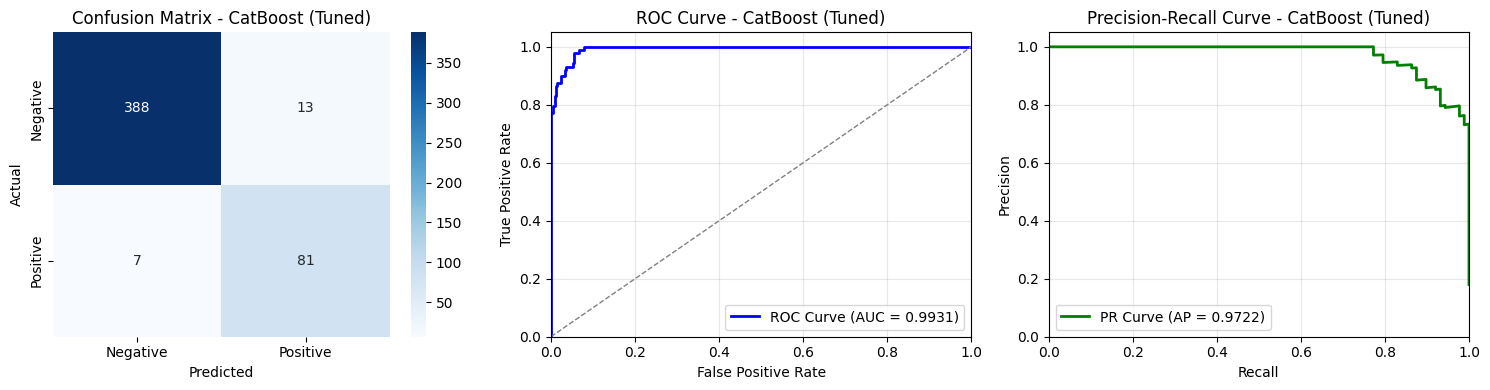

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
axes[0].set_title('Confusion Matrix - CatBoost (Tuned)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - CatBoost (Tuned)')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
axes[2].plot(recall, precision, color='green', lw=2, label=f'PR Curve (AP = {avg_precision:.4f})')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Curve - CatBoost (Tuned)')
axes[2].legend(loc='lower left')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Simpan Model Terbaik

In [12]:
os.makedirs(model_path, exist_ok=True)

joblib.dump(final_model, f"{model_path}/catboost_pipeline.joblib")

fitted_preprocessor = final_model.named_steps['scaler']
joblib.dump(fitted_preprocessor, f"{model_path}/scaler.joblib")

cv_scores = cross_val_score(final_model, X_train, y_train, cv=cv, scoring='recall')

evaluation_results = {
    'best_params': best_params_clean,
    'cv_score': float(study.best_value),
    'test_metrics': {
        'accuracy': float(accuracy),
        'recall': float(recall_val),
        'f1_score': float(f1),
        'roc_auc': float(roc_auc),
        'average_precision': float(avg_precision)
    },
    'cv_scores_per_fold': [float(x) for x in cv_scores],
    'cv_mean': float(cv_scores.mean()),
    'cv_std': float(cv_scores.std()),
    'note': 'Pipeline-based CV (no data leakage)'
}

os.makedirs(f"{result_path}/CatBoost_Tuned", exist_ok=True)
with open(f"{result_path}/CatBoost_Tuned/CatBoost_tuned_evaluation.json", 'w') as f:
    json.dump(evaluation_results, f, indent=4)

print("=" * 60)
print("MODEL DAN HASIL BERHASIL DISIMPAN")
print("=" * 60)

MODEL DAN HASIL BERHASIL DISIMPAN
